In [1]:
import numpy as np
import numpy.random as rnd
from tqdm import tqdm
import scipy.linalg as la
import scipy.integrate as itg

import matplotlib.pyplot as plt

from importlib import reload

import cartpole_tools as cpt

reload(cpt)
%matplotlib inline

# Theory  Question 1

Say that $P$ and $Q$ are positive definite matrices such that
$$
A^\top P + PA = -Q
$$

Say that $\lambda$ is an eigenvalue of $A$. Derive an upper bound on the real-part of $\lambda$ in terms of $P$ and $Q$.

Either write your answer here or attach a hand-written note.

# Theory Question 2

Show that if $A$ has no eigenvalues on the imaginary axis, then for any square matrix, $Q$, there is a unique matrix $P$ such that
$$
A^\top P + PA = -Q
$$

**Correction:** Assume that $A\in\mathbb{R}^{n\times n}$. We must assume that if $\lambda_i$ and $\lambda_j$ are eigenvalues of $A$, then $\lambda_i+\lambda_j\ne 0$. (The problem as stated above could fail if $A$ had eigenvalues at $-1$ and $1$, for example.)

Hint: $\mathrm{vec}(A^\top P)= (I\otimes A^\top) \mathrm{vec}(P)$ and $\mathrm{vec}(PA)=(A^\top \otimes I)\mathrm{vec}(P)$. Recall that $\vec(M)$ corresponds to the vector formed by stacking the columns of the matrix, $M$ and $\otimes$ denotes the Kronecker product. 

**Further Hint:** If $A\in\mathbb{R}^{n\times n}$, then $A$ and  $A^\top$ have the same eigenvalues.

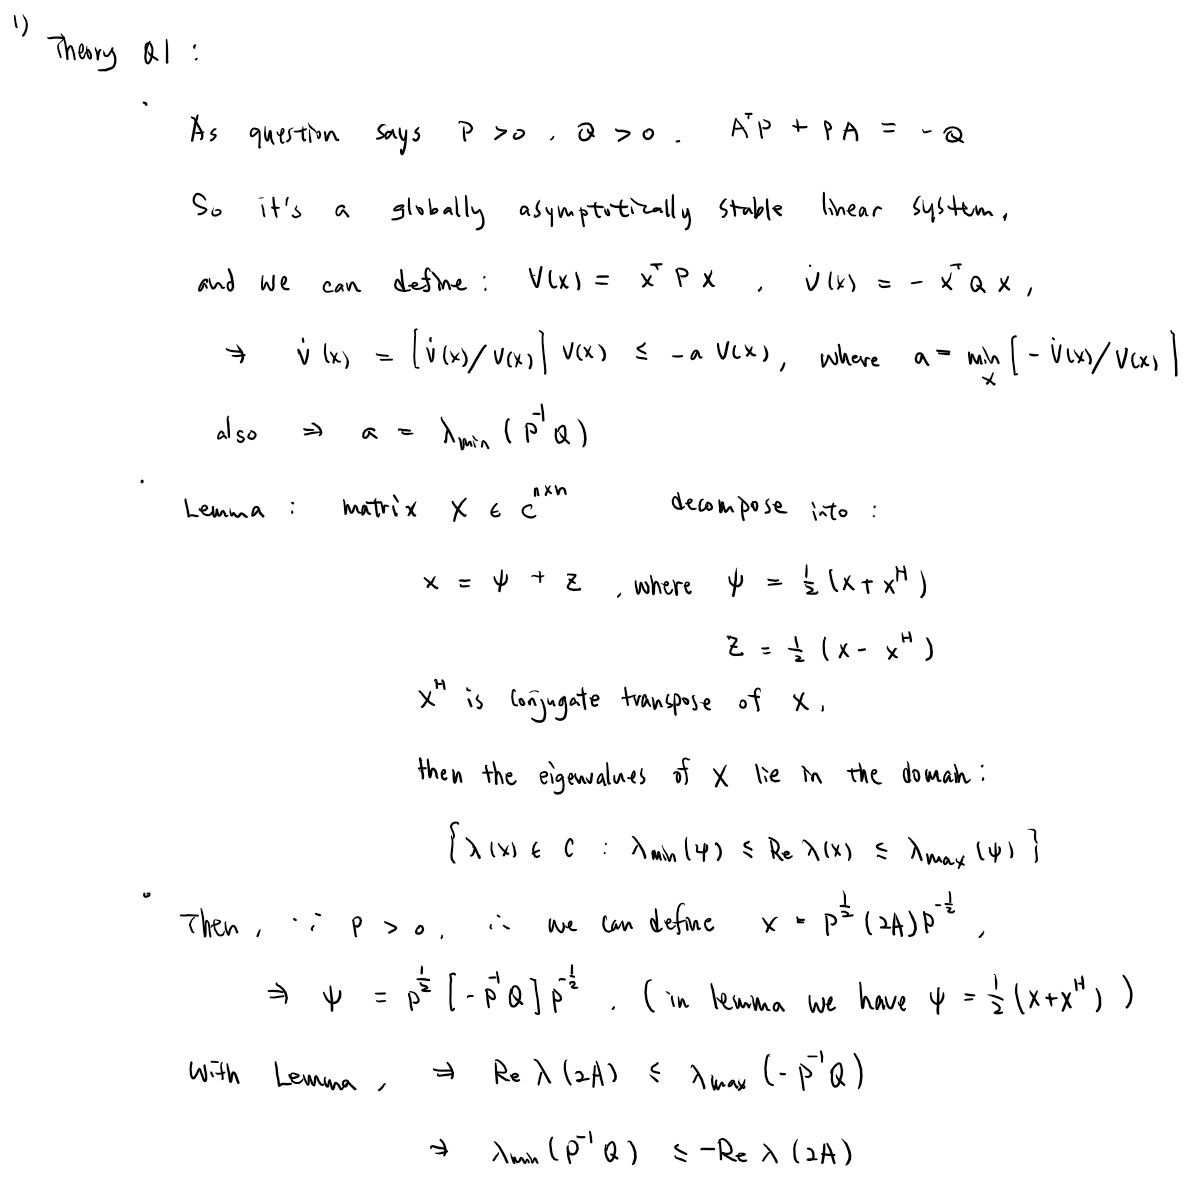

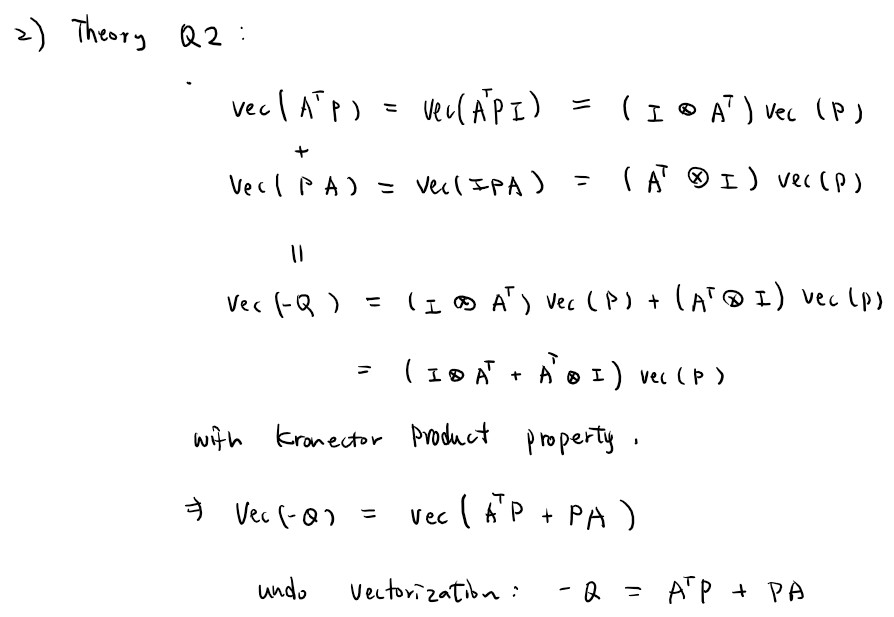

# Coding Question 1

Say that the state of a system  $x(t) = \begin{bmatrix}p(t) \\ v(t)\end{bmatrix}$ and the state has dynamics

\begin{align*}
\dot p(t) &= v(t) \\
\dot v(t) &= -\alpha |v(t)| v(t) + g u(t)
\end{align*}
where $\alpha$ is an unknown drag coefficient and $g$ is an unknown input gain. 

For this problem, set $\alpha = 1.3$ and $g=2.7$

Consider a reference systems given by:
\begin{align*}
\dot x_r(t) &= \begin{bmatrix} 0 & 1 \\
-1 & -1 \end{bmatrix} x_r(t) + \begin{bmatrix} 0 \\ 1 \end{bmatrix}r(t) \\
r(t) &= \sin(t)
\end{align*}

Control this system using the direct MRAC method discussed in class, and in the Lavretsky and Wise book. Plot the states of the original system and the reference system over the time interval $[0,30]$. If you have done it right, the states of the system should track those of the reference system after an initial transient.

You may wish to use the `solve_ivp` command from `scipy.integrate` in order to get a nice-looking simulation. (Otherwise you can do something like Euler integration.)

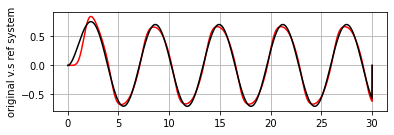

In [5]:
#### Almost done / change x from integer to 2x1 matrix #####

from scipy.integrate import ode
from numpy import sin

# Define variables
alpha = 1.3
g = 2.7
ar = np.array([(0,1),(-1,-1)])
br = np.array([0,1])
gamma = 2


# Change s from numbers to 2x1 vector (still trying)
# Reference model & Target system
def model(t, s):                                  # s: states / t: time

    x, xr, kr_cap, kx_cap, p_dot, v_dot = s       # all should be 2x1 vector
    
    # Time variant variables
    r = sin(t)
    
    # Time invariant variables
    e = x - xr
    u = kr_cap*r + kx_cap*x
    
    p_dot = v_dot                         
    v_dot = -alpha*abs(p_dot)*p_dot + g*u
    x_dot = v_dot
    xr_dot = -xr + r                        
    kr_cap_dot = -gamma*e*r
    kx_cap_dot = -gamma*e*x

    return [x_dot, xr_dot, kr_cap_dot, kx_cap_dot, p_dot, v_dot]

# Solve the ODE & store every parameters at every time step
def main():

    s0 = np.zeros(6)
    t0 = 0
    t1 = 30
    dt = 0.01

    r = ode(model).set_integrator('vode', method='bdf')
    r.set_initial_value(s0, t0)

    s = np.zeros((3001, 6))     
    t = []
    i = 0

    while r.successful() and r.t < t1:              # r.t: current time step of r
        r.integrate(r.t + dt)                       # r.t+t : current time doing integral
        s[i] = r.y                                  # 0: s / 1: sr / 2: kr_cap / 3: kx_cap / 4: p_dot / 5: v_dot
        t.append(r.t)                               # store every time step (0.01 > 0.02...)
        i += 1

    t.append(r.t + dt)
    return s, t

# Plot the Original system & Reference model => check for it maintain stable
if __name__ == '__main__':
    x1, t1 = main()

    s = np.reshape(x1[:,0], (3001,))                # state of system
    sr = np.reshape(x1[:,1], (3001,))               # reference state of system
    kr_cap = np.reshape(x1[:,2], (3001,))
    kx_cap = np.reshape(x1[:,3], (3001,))


    plt.subplot(211)
    plt.plot(t1 , s, 'r', t1, sr, 'k')
    plt.ylabel('original v.s ref system')
    plt.grid()


    plt.show()

# The Swing-Up Problem Revisited

We are going to implement a basic controller for swinging up the inverted pendulum system based on the paper 

"PASSIVITY BASED CONTROL OF THE INVERTED PENDULUM" by Rogelio Lozano and Isabelle Fantoni.

The states of the system are given by:
$$
s = \begin{bmatrix}
q \\
\dot q
\end{bmatrix}=\begin{bmatrix}
x \\
\theta \\
\dot x \\
\dot \theta
\end{bmatrix},
$$
where $x$ is the horizontal position of the cart and $\theta$ is the angle of the pendulum from vertical. See the paper for details on the setup.

The dynamics are given by:

$$
M(q)\ddot q + C(q,\dot q) \dot q + G(q) = \tau
$$


where 

\begin{align*}
M(q) &= \begin{bmatrix}
M+m & m\ell\cos(\theta) \\
m\ell\cos(\theta) & m\ell^2
\end{bmatrix} \\
C(q,\dot q) &= \begin{bmatrix}
0 & -m\ell \dot \theta\sin\theta \\
0 & 0
\end{bmatrix} \\
G(q) &= \begin{bmatrix}
0 \\
-mg\ell \sin(\theta)
\end{bmatrix} \\
\tau &= \begin{bmatrix}
a \\
0
\end{bmatrix}.
\end{align*}

Here $a$ is the action, which corresponds to a force on the cart. (Note there is a bit of a notational clash here, in that $M$ denotes the mass of the cart, while $M(q)$ denotes the mass matrix of the whole system.)

A gym environment for this system is given below, and a short simulation with random inputs is shown.

In [ ]:


    
env = cpt.SwingUp()

  

s = env.reset()

render = True

for step in range(100):
    
    a = 10 * rnd.randn(1)
    s_next,r,done,info = env.step(a)
    s = np.copy(s_next)
    if render:
        env.render()
    
env.close()



# A  Linear-In-Parameters Representation.

Commonly in applications, the dyanmics will have a known functional form that depends on parameters, but we will not know the parameters. 

If we discretize the dynamics via an Euler method, with sampling period $h$, we can arrive at a system of equations of the form:
\begin{align*}
q(t+h)-q(t)&=h\dot q(t) \\
M(q(t)) (\dot q(t+h)-\dot q(t)) + h C(q(t),\dot q(t))\dot q(t) + h G(q(t)) &= h \tau(t)
\end{align*}

In this case, the parameters are $M,m,\ell,g,\theta,h$. Estimating these parameters directly is not always advisable, since many appear in product form, e.g. $m\ell^2$. In this case, an alternative representation that is linear in the parameters is desirable.

Consider the redundant parameter representation given by:
$$
p = \begin{bmatrix}
h \\
M+m \\
m\ell^2 \\
m\ell \\
hm\ell \\
hmg\ell
\end{bmatrix}
$$
Note that if $p$ is known, then all of desired parameters can be computed by algebra. 

Then there is a matrix $\Phi_t$ and a vector $\psi_t$, which are functions of $s(t)$, $s(t+h)$ and $a(t)$ such that
$$
\Phi_t p = \psi_t
$$

So, if we have a collection of samples $(s(kh),s((k+1)h),a(k)$, for $k=0,\ldots,N$, we can estimate $p$ via regularized least-squares:

$$
\hat p_N = \mathrm{argmin}_p \sum_{k=0}^N \| \Phi_{kh}p-\psi_{kh}\|^2 + \alpha \|p\|^2
$$
furthermore, we can compute this estimate recursively.

(Note: A small amount of noise is added to the simulations, so the linear relationship above will not be exact.)

# Coding Question 2 (Incomplete)

Code up the least-squares and plug your estimates into the simulation below. 

The simulation runs a controller that uses the parameter estimates to swing up the pendulum and hold it there. You do not need to build the controller, just the parameter estimates.

My simulation reliably stabilizes the system upright after between 10,000 - 20,000 steps, while using $\alpha=1$ for regularization. 

Plot the error in the parameter estimates. 

Note that the error in the parameter estimates often times will remain fairly large (e.g. above 1 in norm.) This is because once the parameters are reasonably close, the feedback controller is sufficiently robust that it manages to hold the system near its goal state. At this point, the system is barely moving, and so less valuable information about the parameters can be obtained. 


In [ ]:
# True parameters for comparison
h_true = env.tau
m_true = env.masspole
M_true = env.masscart
g_true = env.gravity
ell_true = env.length

param_true = np.array([h_true,m_true,M_true,g_true,ell_true])

In [ ]:
# Modify  this code

Controller = cpt.SwingUpController()

render = False

# The parameter estimates
h = 0
m = 0
M = 0
g = 0
ell = 0
param_est = np.array([h,m,M,g,ell])

param_error = []

for step in tqdm(range(20000)):
    a = Controller.action(s)
    s_next,r,done,info = env.step(a)
    
    # Put some code to estimate  the parameters here
    # Update the vector param_est
    
    
    # This extracts the parameter estimates
    h,m,M,g,ell = param_est
    Controller.update_parameters(h,m,M,g,ell)
    
    # This measures the error
    param_error.append(la.norm(param_est-param_true))
    s = np.copy(s_next)
    
    if render:
        env.render()
    
plt.loglog(param_error)
env.close()